In [ ]:
%matplotlib inline


import os
import itertools
import numpy as np
import torch
import torch.jit
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sklearn.decomposition
import sklearn.manifold
import sklearn.neighbors
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import scipy.stats
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.sparse
import matplotlib.pyplot as plt


In [ ]:
assert torch.cuda.is_available()

## Analyze runs

In [ ]:

from pathlib import Path
import glob
import yaml
from LatentEvolution.latent import ModelParams, LatentModel
from typing import Any, Dict, List, MutableMapping, Tuple

In [ ]:
expt_code = "l1_reg_all"


In [ ]:
# raw data dir
sim_dir = "/groups/saalfeld/home/kumarv4/repos/NeuralGraph/graphs_data/fly/fly_N9_62_1/"

In [ ]:


def flatten_dict(
    d: MutableMapping[str, Any], parent_key: str = "", sep: str = "."
) -> Dict[str, Any]:
    items: List[Tuple[str, Any]] = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)



run_dir_base = Path("/groups/saalfeld/home/kumarv4/repos/NeuralGraph/runs") / expt_code
assert run_dir_base.exists()


run_dirs = [Path(p) for p in glob.glob(f"{run_dir_base}/*")]
configs = []
metrics = []
model_params = {}
metric_keys = None
for run_dir in run_dirs:
    with open(run_dir / "config.yaml") as fin:
        raw = yaml.safe_load(fin)
    config = ModelParams.model_validate(raw)
    model_params[run_dir] = config
    raw_flat = flatten_dict(raw)

    metrics_file = run_dir / "final_metrics.yaml"
    # if not metrics_file.exists():
    #     metrics.append({})
    #     continue
    configs.append(raw_flat)

    with open(metrics_file) as fin:
        raw = yaml.safe_load(fin)
        metrics.append(raw)
        if metric_keys is None:
            metric_keys = sorted(raw.keys())
        else:
            assert metric_keys == sorted(raw.keys())

assert metric_keys is not None, "All runs failed"

config_df = pl.DataFrame(configs)
config_cols = []
for col in config_df.columns:
    if config_df[col].unique().shape[0] > 1:
        config_cols.append(col)
config_cols.sort(key=lambda k: k.count("."))


metrics_df = pl.DataFrame(metrics, schema=metric_keys)

df = pl.concat([config_df, metrics_df], how="horizontal").with_columns(
    pl.Series("run_dir", run_dirs)
).sort(config_cols)

In [ ]:
for row in df.rows(named=True):
    run_dir = row["run_dir"]
    tdf = pl.read_csv(f"{run_dir}/training_log.csv")
    plt.plot(tdf["val_loss"], label=f"l1 weight {row['encoder_params.l1_reg_loss']:.1e}")
plt.yscale("log")
plt.legend()
plt.title("Val loss")
plt.ylim(None, 0.05)

# Analyze one model

In [ ]:
device=torch.device("cuda")

In [ ]:
pick_run_dirs = df.drop_nulls().filter(pl.col("encoder_params.l1_reg_loss") == 1e-3)["run_dir", "encoder_params.l1_reg_loss", "final_val_loss"]
print(pick_run_dirs)
pick_run_dir = pick_run_dirs["run_dir"][0]

# load model

model = LatentModel(model_params[pick_run_dir]).to(device)
model.load_state_dict(torch.load(f"{pick_run_dir}/model_final.pt"))
model.eval()
with open(pick_run_dir / "config.yaml") as fin:
    raw = yaml.safe_load(fin)
config = ModelParams.model_validate(raw)

In [ ]:
df = pl.read_csv(f"{pick_run_dir}/training_log.csv")
plt.plot(df["train_loss"])
plt.plot(df["val_loss"])
plt.yscale("log")

In [ ]:
from LatentEvolution.load_flyvis import SimulationResults, FlyVisSim

In [ ]:
sim_data = SimulationResults.load(f"{sim_dir}x_list_0.npy")

In [ ]:
split = config.training.data_split
val_mat = sim_data[FlyVisSim.VOLTAGE][split.validation_start:split.validation_end]
val_data = torch.tensor(val_mat, device=device)
val_stim = torch.tensor(sim_data[FlyVisSim.STIMULUS][split.validation_start:split.validation_end], device=device)

In [ ]:
# reconstruction

proj = model.encoder(val_data)
recon = model.decoder(proj).detach().cpu().numpy()

In [ ]:

index_to_name = {0: 'Am', 1: 'C2', 2: 'C3', 3: 'CT1(Lo1)', 4: 'CT1(M10)', 5: 'L1', 6: 'L2',
    7: 'L3', 8: 'L4', 9: 'L5', 10: 'Lawf1', 11: 'Lawf2', 12: 'Mi1', 13: 'Mi10',
    14: 'Mi11', 15: 'Mi12', 16: 'Mi13', 17: 'Mi14', 18: 'Mi15', 19: 'Mi2',
    20: 'Mi3', 21: 'Mi4', 22: 'Mi9', 23: 'R1', 24: 'R2', 25: 'R3', 26: 'R4',
    27: 'R5', 28: 'R6', 29: 'R7', 30: 'R8', 31: 'T1', 32: 'T2', 33: 'T2a',
    34: 'T3', 35: 'T4a', 36: 'T4b', 37: 'T4c', 38: 'T4d', 39: 'T5a', 40: 'T5b',
    41: 'T5c', 42: 'T5d', 43: 'Tm1', 44: 'Tm16', 45: 'Tm2', 46: 'Tm20', 47: 'Tm28',
    48: 'Tm3', 49: 'Tm30', 50: 'Tm4', 51: 'Tm5Y', 52: 'Tm5a', 53: 'Tm5b',
    54: 'Tm5c', 55: 'Tm9', 56: 'TmY10', 57: 'TmY13', 58: 'TmY14', 59: 'TmY15',
    60: 'TmY18', 61: 'TmY3', 62: 'TmY4', 63: 'TmY5a', 64: 'TmY9'
}
neuron_type_name = [
    "Am", "C2", "C3", "CT1(Lo1)", "CT1(M10)",
    "L1", "L2", "L3", "L4", "L5", "Lawf1", "Lawf2",
    "Mi1", "Mi10", "Mi11", "Mi12", "Mi13", "Mi14", "Mi15", "Mi2", "Mi3", "Mi4", "Mi9",
    "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8",
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm16", "Tm2", "Tm20", "Tm28", "Tm3", "Tm30", "Tm4", "Tm5Y",
    "Tm5a", "Tm5b", "Tm5c", "Tm9", "TmY10", "TmY13", "TmY14",
    "TmY15", "TmY18", "TmY3", "TmY4", "TmY5a", "TmY9"
]
neuron_type_index = {t: i for i, t in enumerate(neuron_type_name)}

def compute_ixs_per_type(neuron_types):
    """Compute indices corresponding to each neuron type."""
    order = np.argsort(neuron_types)
    uniq_types, start_index = np.unique(neuron_types[order], return_index=True)
    num_neuron_types = len(uniq_types)
    assert (uniq_types == np.arange(num_neuron_types)).all(), "breaks assumptions"
    breaks = np.zeros(len(uniq_types)+1, dtype=np.int64)
    breaks[:-1] = start_index
    breaks[-1] = len(neuron_types)
    return [
        order[breaks[i]:breaks[i+1]] for i in range(num_neuron_types)
    ]
neuron_types = sim_data[FlyVisSim.TYPE][0]
neuron_ixs_by_type = compute_ixs_per_type(neuron_types)


In [ ]:
# val_stim.shape, val_data.shape
evolved = model(val_data, val_stim[:, :1736]).detach().cpu()

In [ ]:

plot_neuron_types = np.sort(np.random.choice(neuron_type_name, 10))
# plot_neuron_types = ['R1', 'R7', 'C2', 'Mi11', 'Tm1', 'Tm4', 'Tm30']

_, ax = plt.subplots(len(plot_neuron_types), 1, figsize=(8, 16), sharex=True)
t0 = 0
T = val_mat.shape[0]
tvals = np.arange(t0, t0 + T)
rng = np.random.default_rng(seed=123)
picks = [rng.choice(nixs) for nixs in neuron_ixs_by_type]

for i, ptype in enumerate(plot_neuron_types):
    nix = picks[neuron_type_index[ptype]]
    true_trace = val_mat[:, nix]
    p = ax[i].plot(
        tvals,
        recon[:, nix],
        ls="dashed",
        # marker=".",
        label="reconstruct each time point",
    )

    ax[i].plot(tvals, true_trace, lw=3, color=p[-1].get_color(), alpha=0.2)
    ylim = ax[i].get_ylim()
    yc = 0.5*(ylim[0] + ylim[1])
    ylen = ylim[1] - ylim[0]
    if ylen < 2:
        ylim = (yc-1, yc+1)


    # # ax[i].set_ylim(1, 2)
    # # # time evolve
    # ax[i].plot(
    #     tvals,
    #     evolved[:, nix],
    #     color=p[-1].get_color(),
    #     ls="dotted",
    #     label="learn linear evolver",
    # )


    ax[i].set_ylim(*ylim)
    ax[i].set_ylabel(ptype)
plt.xlim(0, 100)
plt.subplots_adjust(hspace=0.2)

In [ ]:
# evolve multiple time steps


# go to latent space
proj_stim = model.stimulus_encoder(val_stim[:, :1736])
_, stim_dim = proj_stim.shape
proj = model.encoder(val_data)
evolver_input = torch.concatenate([proj, proj_stim], dim=1)
offset = 0
evolver_outputs = [proj]
for i in range(5):
    evolver_output = model.evolver(evolver_input)
    evolver_input[:, :] = evolver_output
    evolver_input[:, -stim_dim:] = proj_stim
    evolver_outputs.append(evolver_output[:, :-stim_dim])

evolver_outputs = torch.stack(evolver_outputs, dim=0)
neuron_outputs = model.decoder(evolver_outputs.reshape((-1, 256))).reshape((6, -1, 13741))

In [ ]:
neuron_outputs[0]

In [ ]:
val_data

In [ ]:
delta_val = np.diff(val_mat, axis=0)
pred_delta = evolved[:-1] - val_mat[:-1]

In [ ]:
vmin, vmax = delta_val.min(), delta_val.max()

In [ ]:
nbins=50
bins = np.linspace(np.floor(vmin), np.ceil(vmax), nbins+1)
mps = 0.5*(bins[1:] + bins[:-1])
ixs = np.searchsorted(bins, delta_val)


In [ ]:

den = np.bincount(ixs.ravel(), minlength=nbins+1)
num = np.bincount(ixs.ravel(), weights=pred_delta.ravel(), minlength=nbins+1)
num2 = np.bincount(ixs.ravel(), weights=np.power(pred_delta.ravel(), 2), minlength=nbins+1)
mean = num/den
err2 = num2/den - num**2 / den**2

In [ ]:
sigma = np.sqrt(err2)

In [ ]:
plt.errorbar(bins, mean, yerr=sigma, marker=".", capsize=3)
plt.xlabel("True change t->t+1")
plt.ylabel("Predicted change t->t+1")
plt.plot([-5, 5], [-5, 5])

In [ ]:
plt.plot(bins, den / den.sum())

In [ ]:
proj1 = proj.detach().cpu().numpy()

## Compute the jacobian & look for structure

In [ ]:

wt = torch.load(f"{sim_dir}/weights.pt", map_location="cpu").numpy()
edge_index = torch.load(f"{sim_dir}/edge_index.pt", map_location="cpu").numpy()
voltage_rest = torch.load(f"{sim_dir}/V_i_rest.pt", map_location="cpu").numpy()
taus = torch.load(f"{sim_dir}/taus.pt", map_location="cpu").numpy()
wmat = scipy.sparse.csc_matrix((wt, (edge_index[0], edge_index[1])))

In [ ]:
from torch.func import jacrev, vmap


def model_combined(xs):
    """
    xs: concatenated [x, s] of shape (13741 + 1736,)
    """
    x = xs[:13741]
    s = xs[13741:]
    return model(x.unsqueeze(0), s.unsqueeze(0)).squeeze(0)
x_points = np.zeros((10, 13741), dtype=np.float32)
x_points[:, 0] = np.linspace(-20, 20, 10)
x_points = torch.tensor(x_points, device=device)
s_points = torch.zeros((10, 1736), device=device)
# For multiple points
jac_combined_all = vmap(lambda xs: jacrev(model_combined)(xs))(
    torch.cat([x_points, s_points], dim=1)
).detach().cpu().numpy()  # shape: (num_points, 13741, 15477)

In [ ]:
print(f"Allocated: {torch.cuda.memory_allocated()/1e6:.1f} MB")
print(f"Reserved:  {torch.cuda.memory_reserved()/1e6:.1f} MB")

In [ ]:
rvals = np.random.choice(jac_combined_all[5].ravel(), 1000)
evals = np.random.choice(jac_combined_all[5, edge_index[1], edge_index[0]], 1000)
tvals = np.random.choice(wmat.data, 1000)
plt.hist(rvals, bins=np.linspace(-0.02, 0.02, 51), alpha=0.2)
plt.hist(evals, bins=np.linspace(-0.02, 0.02, 51), alpha=0.2)
plt.hist(tvals*.02, bins=np.linspace(-0.02, 0.02, 51), alpha=0.2)

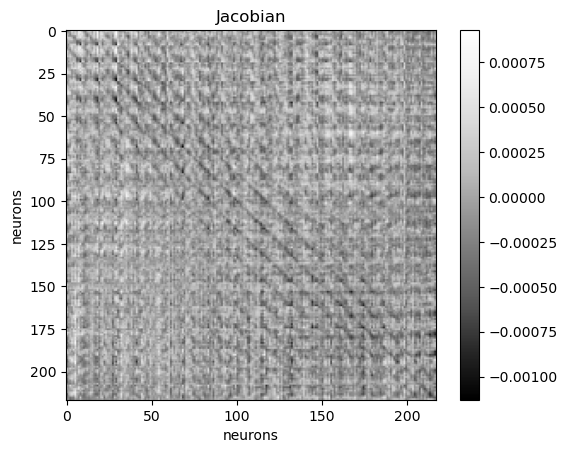

In [15]:
disp_mat = jac_combined_all[5, 0:217, 1736:1736 + 217]
plt.imshow(disp_mat , cmap="Greys_r")
plt.xlabel("neurons")
plt.ylabel("neurons")
plt.title("Jacobian")
plt.colorbar()

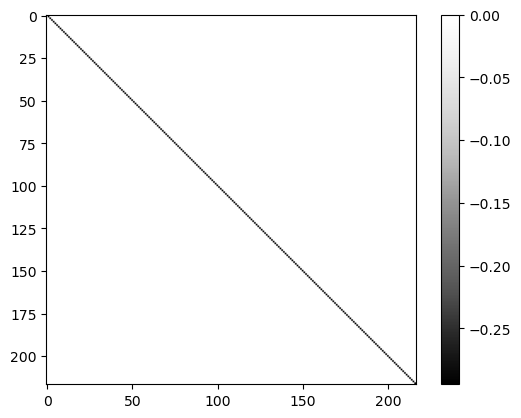

In [16]:
plt.imshow(wmat[217:217+217, 1736:1736 + 217].todense(), cmap="Greys_r")
plt.colorbar()